In \[1\]:

    import numpy as np

In \[2\]:

    import pandas as pd

In \[3\]:

    import cv2

In \[4\]:

    import pickle

In \[5\]:

    from os import listdir

In \[6\]:

    from sklearn.preprocessing import LabelBinarizer

In \[7\]:

    import tensorflow.keras

In \[8\]:

    from tensorflow.keras.models import Sequential

In \[9\]:

    from tensorflow.keras import layers

In \[10\]:

    from tensorflow.keras.layers import Input, Conv2D, Reshape, multiply, Permute, Activation, MaxPooling2D, Flatten, BatchNormalization, Dropout, Dense

In \[11\]:

    from tensorflow.keras import backend as K

In \[12\]:

    from tensorflow.keras.preprocessing.image import ImageDataGenerator

In \[13\]:

    from tensorflow.keras.optimizers import Adam

In \[14\]:

    from tensorflow.keras.preprocessing import image

In \[15\]:

    from tensorflow.keras.preprocessing.image import img_to_array

In \[16\]:

    from __future__ import print_function

In \[17\]:

    from sklearn.preprocessing import MultiLabelBinarizer

In \[18\]:

    from sklearn.model_selection import train_test_split

In \[19\]:

    import matplotlib.pyplot as plt

In \[20\]:

    default_image_size = tuple((256, 256))
    image_size = 0
    directory_root = 'Dataset/'
    width=256
    height=256
    depth=3

In \[21\]:

    def convert_image_to_array(image_dir):
        try:
            image = cv2.imread(image_dir)
            if image is not None :
                image = cv2.resize(image, default_image_size)   
                return img_to_array(image)
            else :
                return np.array([])
        except Exception as e:
            print(f"Error : {e}")
            return None

In \[22\]:

    EPOCHS = 25
    INIT_LR = 1e-3
    BS = 32

In \[23\]:

    image_list, label_list = [], []
    try:
        print("[INFO] Loading images ...")
        root_dir = listdir(directory_root)
        for directory in root_dir :
            if directory == ".DS_Store" :
                root_dir.remove(directory)

        for plant_folder in root_dir :
            plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
            
            for disease_folder in plant_disease_folder_list :
                if disease_folder == ".DS_Store" :
                    plant_disease_folder_list.remove(disease_folder)

            for plant_disease_folder in plant_disease_folder_list:
                print(f"[INFO] Processing {plant_disease_folder} ...")
                plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
                    
                for single_plant_disease_image in plant_disease_image_list :
                    if single_plant_disease_image == ".DS_Store" :
                        plant_disease_image_list.remove(single_plant_disease_image)

                for image in plant_disease_image_list[:250]:
                    image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                    if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                        image_list.append(convert_image_to_array(image_directory))
                        label_list.append(plant_disease_folder)
        print("[INFO] Image loading completed")  
    except Exception as e:
        print(f"Error : {e}")

    [INFO] Loading images ...
    [INFO] Processing Pepper__bell___Bacterial_spot ...
    [INFO] Processing Pepper__bell___healthy ...
    [INFO] Processing Potato___Early_blight ...
    [INFO] Processing Potato___healthy ...
    [INFO] Processing Potato___Late_blight ...
    [INFO] Processing Tomato_Bacterial_spot ...
    [INFO] Processing Tomato_Early_blight ...
    [INFO] Processing Tomato_healthy ...
    [INFO] Processing Tomato_Late_blight ...
    [INFO] Processing Tomato_Leaf_Mold ...
    [INFO] Processing Tomato_Septoria_leaf_spot ...
    [INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
    [INFO] Processing Tomato__Target_Spot ...
    [INFO] Processing Tomato__Tomato_mosaic_virus ...
    [INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
    [INFO] Image loading completed

In \[24\]:

    image_size = len(image_list)
    image_size

Out\[24\]:

    3652

In \[25\]:

    label_binarizer = LabelBinarizer()
    image_labels = label_binarizer.fit_transform(label_list)
    pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
    n_classes = len(label_binarizer.classes_)

In \[26\]:

    print(label_binarizer.classes_)

    ['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
     'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
     'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
     'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
     'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
     'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
     'Tomato_healthy']

In \[27\]:

    np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In \[28\]:

    print("[INFO] Spliting data to train, test")
    x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

    [INFO] Spliting data to train, test

In \[29\]:

    aug = ImageDataGenerator(
        rotation_range=25, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2, 
        zoom_range=0.2,horizontal_flip=True, 
        fill_mode="nearest")

In \[30\]:

    def create_model():
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(n_classes))
        model.add(Activation("softmax"))
        return model

In \[31\]:

    model = create_model()

In \[32\]:

    model.summary()

    Model: "sequential"
    _________________________________________________________________
     Layer (type)                Output Shape              Param #   
    =================================================================
     conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                     
     activation (Activation)     (None, 256, 256, 32)      0         
                                                                     
     batch_normalization (BatchN  (None, 256, 256, 32)     128       
     ormalization)                                                   
                                                                     
     max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
     )                                                               
                                                                     
     dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                     
     conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                     
     activation_1 (Activation)   (None, 85, 85, 64)        0         
                                                                     
     batch_normalization_1 (Batc  (None, 85, 85, 64)       256       
     hNormalization)                                                 
                                                                     
     conv2d_2 (Conv2D)           (None, 85, 85, 64)        36928     
                                                                     
     activation_2 (Activation)   (None, 85, 85, 64)        0         
                                                                     
     batch_normalization_2 (Batc  (None, 85, 85, 64)       256       
     hNormalization)                                                 
                                                                     
     max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
     2D)                                                             
                                                                     
     dropout_1 (Dropout)         (None, 42, 42, 64)        0         
                                                                     
     conv2d_3 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                     
     activation_3 (Activation)   (None, 42, 42, 128)       0         
                                                                     
     batch_normalization_3 (Batc  (None, 42, 42, 128)      512       
     hNormalization)                                                 
                                                                     
     conv2d_4 (Conv2D)           (None, 42, 42, 128)       147584    
                                                                     
     activation_4 (Activation)   (None, 42, 42, 128)       0         
                                                                     
     batch_normalization_4 (Batc  (None, 42, 42, 128)      512       
     hNormalization)                                                 
                                                                     
     max_pooling2d_2 (MaxPooling  (None, 21, 21, 128)      0         
     2D)                                                             
                                                                     
     dropout_2 (Dropout)         (None, 21, 21, 128)       0         
                                                                     
     flatten (Flatten)           (None, 56448)             0         
                                                                     
     dense (Dense)               (None, 1024)              57803776  
                                                                     
     activation_5 (Activation)   (None, 1024)              0         
                                                                     
     batch_normalization_5 (Batc  (None, 1024)             4096      
     hNormalization)                                                 
                                                                     
     dropout_3 (Dropout)         (None, 1024)              0         
                                                                     
     dense_1 (Dense)             (None, 15)                15375     
                                                                     
     activation_6 (Activation)   (None, 15)                0         
                                                                     
    =================================================================
    Total params: 58,102,671
    Trainable params: 58,099,791
    Non-trainable params: 2,880
    _________________________________________________________________

In \[33\]:

    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    s:\anacondaprogramdata\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
      super().__init__(name, **kwargs)

In \[34\]:

    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In \[35\]:

    history = model.fit(
        aug.flow(x_train, y_train, batch_size=BS),
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train) // BS,
        epochs=EPOCHS, verbose=1
        )

    Epoch 1/25
    91/91 [==============================] - 204s 2s/step - loss: 0.5453 - accuracy: 0.2665 - val_loss: 1.0369 - val_accuracy: 0.0657
    Epoch 2/25
    91/91 [==============================] - 195s 2s/step - loss: 0.1642 - accuracy: 0.5625 - val_loss: 0.7942 - val_accuracy: 0.1094
    Epoch 3/25
    91/91 [==============================] - 203s 2s/step - loss: 0.1400 - accuracy: 0.6151 - val_loss: 3.0979 - val_accuracy: 0.0917
    Epoch 4/25
    91/91 [==============================] - 200s 2s/step - loss: 0.1287 - accuracy: 0.6570 - val_loss: 0.5108 - val_accuracy: 0.1204
    Epoch 5/25
    91/91 [==============================] - 199s 2s/step - loss: 0.1210 - accuracy: 0.7009 - val_loss: 11.2490 - val_accuracy: 0.1176
    Epoch 6/25
    91/91 [==============================] - 205s 2s/step - loss: 0.2032 - accuracy: 0.5358 - val_loss: 0.5146 - val_accuracy: 0.2640
    Epoch 7/25
    91/91 [==============================] - 201s 2s/step - loss: 0.1537 - accuracy: 0.6251 - val_loss: 0.4211 - val_accuracy: 0.3228
    Epoch 8/25
    91/91 [==============================] - 202s 2s/step - loss: 0.1265 - accuracy: 0.6975 - val_loss: 0.1599 - val_accuracy: 0.5732
    Epoch 9/25
    91/91 [==============================] - 200s 2s/step - loss: 0.1100 - accuracy: 0.7362 - val_loss: 0.2980 - val_accuracy: 0.4501
    Epoch 10/25
    91/91 [==============================] - 201s 2s/step - loss: 0.0983 - accuracy: 0.7615 - val_loss: 0.0722 - val_accuracy: 0.8085
    Epoch 11/25
    91/91 [==============================] - 202s 2s/step - loss: 0.0885 - accuracy: 0.7902 - val_loss: 0.2106 - val_accuracy: 0.5650
    Epoch 12/25
    91/91 [==============================] - 205s 2s/step - loss: 0.0834 - accuracy: 0.8024 - val_loss: 0.6097 - val_accuracy: 0.2818
    Epoch 13/25
    91/91 [==============================] - 203s 2s/step - loss: 0.1121 - accuracy: 0.7234 - val_loss: 1.5300 - val_accuracy: 0.2285
    Epoch 14/25
    91/91 [==============================] - 204s 2s/step - loss: 0.0883 - accuracy: 0.7757 - val_loss: 0.8630 - val_accuracy: 0.2818
    Epoch 15/25
    91/91 [==============================] - 207s 2s/step - loss: 0.0891 - accuracy: 0.7875 - val_loss: 0.4401 - val_accuracy: 0.3653
    Epoch 16/25
    91/91 [==============================] - 211s 2s/step - loss: 0.0804 - accuracy: 0.8069 - val_loss: 0.2147 - val_accuracy: 0.6142
    Epoch 17/25
    91/91 [==============================] - 206s 2s/step - loss: 0.0740 - accuracy: 0.8197 - val_loss: 0.5740 - val_accuracy: 0.3037
    Epoch 18/25
    91/91 [==============================] - 208s 2s/step - loss: 0.0690 - accuracy: 0.8411 - val_loss: 0.2847 - val_accuracy: 0.4651
    Epoch 19/25
    91/91 [==============================] - 209s 2s/step - loss: 0.0689 - accuracy: 0.8359 - val_loss: 0.1014 - val_accuracy: 0.7592
    Epoch 20/25
    91/91 [==============================] - 207s 2s/step - loss: 0.0634 - accuracy: 0.8536 - val_loss: 0.1485 - val_accuracy: 0.6566
    Epoch 21/25
    91/91 [==============================] - 210s 2s/step - loss: 0.0589 - accuracy: 0.8647 - val_loss: 0.7451 - val_accuracy: 0.3146
    Epoch 22/25
    91/91 [==============================] - 208s 2s/step - loss: 0.0868 - accuracy: 0.7833 - val_loss: 0.9171 - val_accuracy: 0.2421
    Epoch 23/25
    91/91 [==============================] - 205s 2s/step - loss: 0.0700 - accuracy: 0.8339 - val_loss: 0.2467 - val_accuracy: 0.5677
    Epoch 24/25
    91/91 [==============================] - 206s 2s/step - loss: 0.0585 - accuracy: 0.8678 - val_loss: 0.1431 - val_accuracy: 0.7031
    Epoch 25/25
    91/91 [==============================] - 205s 2s/step - loss: 0.0537 - accuracy: 0.8789 - val_loss: 0.0609 - val_accuracy: 0.8659

In \[36\]:

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

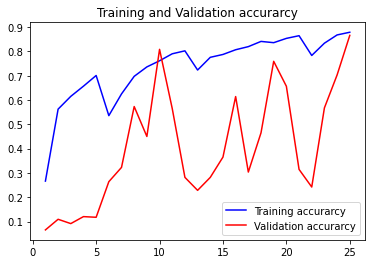

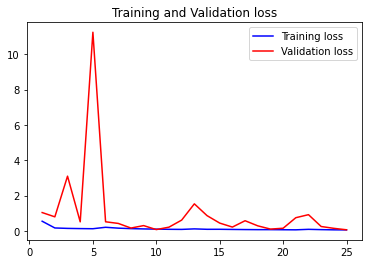

In \[37\]:

    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

    [INFO] Calculating model accuracy
    23/23 [==============================] - 9s 388ms/step - loss: 0.0609 - accuracy: 0.8659
    Test Accuracy: 86.59370541572571

In \[ \]:

     

In \[41\]:

    def squeeze_excite_block(input, ratio=16):
        init = input
        channel_axis = 1 if K.image_data_format() == "channels_first" else -1
        filters = init._keras_shape[channel_axis]
        se_shape = (1, 1, filters)

        se = GlobalAveragePooling2D()(init)
        se = Reshape(se_shape)(se)
        se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

        if K.image_data_format() == 'channels_first':
            se = Permute((3, 1, 2))(se)

        x = multiply([init, se])
        return x

In \[42\]:

    def squeeze_excite_block(input, ratio=16):
        init = input
        channel_axis = 1 if K.image_data_format() == "channels_first" else -1
        filters = init._keras_shape[channel_axis]
        se_shape = (1, 1, filters)

        se = GlobalAveragePooling2D()(init)
        se = Reshape(se_shape)(se)
        se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
        se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

        if K.image_data_format() == 'channels_first':
            se = Permute((3, 1, 2))(se)

        x = multiply([init, se])
        return x

In \[47\]:

    class squeezeExcitation(layers.Layer):
        WEIGHTS_PATH = ''
        WEIGHTS_PATH_NO_TOP = ''


        def _conv2d_bn(self,x,
                       filters,
                       num_row,
                       num_col,
                       padding='same',
                       strides=(1, 1),
                       name=None):
            if name is not None:
                bn_name = name + '_bn'
                conv_name = name + '_conv'
            else:
                bn_name = None
                conv_name = None
            if K.image_data_format() == 'channels_first':
                bn_axis = 1
            else:
                bn_axis = 3
            x = Conv2D(
                filters, (num_row, num_col),
                strides=strides,
                padding=padding,
                use_bias=False,
                name=conv_name)(x)
            x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
            x = Activation('relu', name=name)(x)
            return x


        def SEInceptionV3(self,include_top=True,
                          weights=None,
                          input_tensor=None,
                          input_shape=None,
                          pooling=None,
                          classes=1000):
            
            if weights not in {'imagenet', None}:
                raise ValueError('The `weights` argument should be either '
                                 '`None` (random initialization) or `imagenet` '
                                 '(pre-training on ImageNet).')

            if weights == 'imagenet' and include_top and classes != 1000:
                raise ValueError('If using `weights` as imagenet with `include_top`'
                                 ' as true, `classes` should be 1000')

            # Determine proper input shape
            input_shape = _obtain_input_shape(
                input_shape,
                default_size=299,
                min_size=139,
                data_format=K.image_data_format(),
                require_flatten=include_top)

            if input_tensor is None:
                img_input = Input(shape=input_shape)
            else:
                if not K.is_keras_tensor(input_tensor):
                    img_input = Input(tensor=input_tensor, shape=input_shape)
                else:
                    img_input = input_tensor

            if K.image_data_format() == 'channels_first':
                channel_axis = 1
            else:
                channel_axis = 3

            x = _conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
            x = _conv2d_bn(x, 32, 3, 3, padding='valid')
            x = _conv2d_bn(x, 64, 3, 3)
            x = MaxPooling2D((3, 3), strides=(2, 2))(x)

            x = _conv2d_bn(x, 80, 1, 1, padding='valid')
            x = _conv2d_bn(x, 192, 3, 3, padding='valid')
            x = MaxPooling2D((3, 3), strides=(2, 2))(x)

            branch1x1 = _conv2d_bn(x, 64, 1, 1)

            branch5x5 = _conv2d_bn(x, 48, 1, 1)
            branch5x5 = _conv2d_bn(branch5x5, 64, 5, 5)

            branch3x3dbl = _conv2d_bn(x, 64, 1, 1)
            branch3x3dbl = _conv2d_bn(branch3x3dbl, 96, 3, 3)
            branch3x3dbl = _conv2d_bn(branch3x3dbl, 96, 3, 3)

            branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
            branch_pool = _conv2d_bn(branch_pool, 32, 1, 1)
            x = layers.concatenate(
                [branch1x1, branch5x5, branch3x3dbl, branch_pool],
                axis=channel_axis,
                name='mixed0')

            x = squeeze_excite_block(x)

            branch1x1 = _conv2d_bn(x, 64, 1, 1)

            branch5x5 = _conv2d_bn(x, 48, 1, 1)
            branch5x5 = _conv2d_bn(branch5x5, 64, 5, 5)

            branch3x3dbl = _conv2d_bn(x, 64, 1, 1)
            branch3x3dbl = _conv2d_bn(branch3x3dbl, 96, 3, 3)
            branch3x3dbl = _conv2d_bn(branch3x3dbl, 96, 3, 3)

            branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
            branch_pool = _conv2d_bn(branch_pool, 64, 1, 1)
            x = layers.concatenate(
                [branch1x1, branch5x5, branch3x3dbl, branch_pool],
                axis=channel_axis,
                name='mixed1')

            x = squeeze_excite_block(x)

            branch1x1 = _conv2d_bn(x, 64, 1, 1)

            branch5x5 = _conv2d_bn(x, 48, 1, 1)
            branch5x5 = _conv2d_bn(branch5x5, 64, 5, 5)

            branch3x3dbl = _conv2d_bn(x, 64, 1, 1)
            branch3x3dbl = _conv2d_bn(branch3x3dbl, 96, 3, 3)
            branch3x3dbl = _conv2d_bn(branch3x3dbl, 96, 3, 3)

            branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
            branch_pool = _conv2d_bn(branch_pool, 64, 1, 1)
            x = layers.concatenate(
                [branch1x1, branch5x5, branch3x3dbl, branch_pool],
                axis=channel_axis,
                name='mixed2')

            x = squeeze_excite_block(x)

            branch3x3 = _conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

            branch3x3dbl = _conv2d_bn(x, 64, 1, 1)
            branch3x3dbl = _conv2d_bn(branch3x3dbl, 96, 3, 3)
            branch3x3dbl = _conv2d_bn(
                branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

            branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
            x = layers.concatenate(
                [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

            x = squeeze_excite_block(x)

            branch1x1 = _conv2d_bn(x, 192, 1, 1)

            branch7x7 = _conv2d_bn(x, 128, 1, 1)
            branch7x7 = _conv2d_bn(branch7x7, 128, 1, 7)
            branch7x7 = _conv2d_bn(branch7x7, 192, 7, 1)

            branch7x7dbl = _conv2d_bn(x, 128, 1, 1)
            branch7x7dbl = _conv2d_bn(branch7x7dbl, 128, 7, 1)
            branch7x7dbl = _conv2d_bn(branch7x7dbl, 128, 1, 7)
            branch7x7dbl = _conv2d_bn(branch7x7dbl, 128, 7, 1)
            branch7x7dbl = _conv2d_bn(branch7x7dbl, 192, 1, 7)

            branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
            branch_pool = _conv2d_bn(branch_pool, 192, 1, 1)
            x = layers.concatenate(
                [branch1x1, branch7x7, branch7x7dbl, branch_pool],
                axis=channel_axis,
                name='mixed4')

            x = squeeze_excite_block(x)


            for i in range(2):
                branch1x1 = _conv2d_bn(x, 192, 1, 1)

                branch7x7 = _conv2d_bn(x, 160, 1, 1)
                branch7x7 = _conv2d_bn(branch7x7, 160, 1, 7)
                branch7x7 = _conv2d_bn(branch7x7, 192, 7, 1)

                branch7x7dbl = _conv2d_bn(x, 160, 1, 1)
                branch7x7dbl = _conv2d_bn(branch7x7dbl, 160, 7, 1)
                branch7x7dbl = _conv2d_bn(branch7x7dbl, 160, 1, 7)
                branch7x7dbl = _conv2d_bn(branch7x7dbl, 160, 7, 1)
                branch7x7dbl = _conv2d_bn(branch7x7dbl, 192, 1, 7)

                branch_pool = AveragePooling2D(
                    (3, 3), strides=(1, 1), padding='same')(x)
                branch_pool = _conv2d_bn(branch_pool, 192, 1, 1)
                x = layers.concatenate(
                    [branch1x1, branch7x7, branch7x7dbl, branch_pool],
                    axis=channel_axis,
                    name='mixed' + str(5 + i))

                x = squeeze_excite_block(x)

            branch1x1 = _conv2d_bn(x, 192, 1, 1)

            branch7x7 = _conv2d_bn(x, 192, 1, 1)
            branch7x7 = _conv2d_bn(branch7x7, 192, 1, 7)
            branch7x7 = _conv2d_bn(branch7x7, 192, 7, 1)

            branch7x7dbl = _conv2d_bn(x, 192, 1, 1)
            branch7x7dbl = _conv2d_bn(branch7x7dbl, 192, 7, 1)
            branch7x7dbl = _conv2d_bn(branch7x7dbl, 192, 1, 7)
            branch7x7dbl = _conv2d_bn(branch7x7dbl, 192, 7, 1)
            branch7x7dbl = _conv2d_bn(branch7x7dbl, 192, 1, 7)

            branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
            branch_pool = _conv2d_bn(branch_pool, 192, 1, 1)
            x = layers.concatenate(
                [branch1x1, branch7x7, branch7x7dbl, branch_pool],
                axis=channel_axis,
                name='mixed7')

            x = squeeze_excite_block(x)

            branch3x3 = _conv2d_bn(x, 192, 1, 1)
            branch3x3 = _conv2d_bn(branch3x3, 320, 3, 3,
                                   strides=(2, 2), padding='valid')

            branch7x7x3 = _conv2d_bn(x, 192, 1, 1)
            branch7x7x3 = _conv2d_bn(branch7x7x3, 192, 1, 7)
            branch7x7x3 = _conv2d_bn(branch7x7x3, 192, 7, 1)
            branch7x7x3 = _conv2d_bn(
                branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

            branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
            x = layers.concatenate(
                [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

            x = squeeze_excite_block(x)

            for i in range(2):
                branch1x1 = _conv2d_bn(x, 320, 1, 1)

                branch3x3 = _conv2d_bn(x, 384, 1, 1)
                branch3x3_1 = _conv2d_bn(branch3x3, 384, 1, 3)
                branch3x3_2 = _conv2d_bn(branch3x3, 384, 3, 1)
                branch3x3 = layers.concatenate(
                    [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

                branch3x3dbl = _conv2d_bn(x, 448, 1, 1)
                branch3x3dbl = _conv2d_bn(branch3x3dbl, 384, 3, 3)
                branch3x3dbl_1 = _conv2d_bn(branch3x3dbl, 384, 1, 3)
                branch3x3dbl_2 = _conv2d_bn(branch3x3dbl, 384, 3, 1)
                branch3x3dbl = layers.concatenate(
                    [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

                branch_pool = AveragePooling2D(
                    (3, 3), strides=(1, 1), padding='same')(x)
                branch_pool = _conv2d_bn(branch_pool, 192, 1, 1)
                x = layers.concatenate(
                    [branch1x1, branch3x3, branch3x3dbl, branch_pool],
                    axis=channel_axis,
                    name='mixed' + str(9 + i))

                # squeeze and excite block
                x = squeeze_excite_block(x)

            if include_top:
                # Classification block
                x = GlobalAveragePooling2D(name='avg_pool')(x)
                x = Dense(classes, activation='softmax', name='predictions')(x)
            else:
                if pooling == 'avg':
                    x = GlobalAveragePooling2D()(x)
                elif pooling == 'max':
                    x = GlobalMaxPooling2D()(x)

            if input_tensor is not None:
                inputs = get_source_inputs(input_tensor)
            else:
                inputs = img_input
            # Create model.
            model = Model(inputs, x, name='inception_v3')

            return model


        def preprocess_input(self,x):
            x /= 255.
            x -= 0.5
            x *= 2.
            return x

In \[48\]:

    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(squeezeExcitation())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(squeezeExcitation())
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(squeezeExcitation())
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(squeezeExcitation())
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(squeezeExcitation())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))

In \[49\]:

    model.summary()

    Model: "sequential_1"
    _________________________________________________________________
     Layer (type)                Output Shape              Param #   
    =================================================================
     conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                     
     activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                     
     batch_normalization_6 (Batc  (None, 256, 256, 32)     128       
     hNormalization)                                                 
                                                                     
     max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
     2D)                                                             
                                                                     
     squeeze_excitation (squeeze  (None, 85, 85, 32)       0         
     Excitation)                                                     
                                                                     
     dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                     
     conv2d_6 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                     
     activation_8 (Activation)   (None, 85, 85, 64)        0         
                                                                     
     batch_normalization_7 (Batc  (None, 85, 85, 64)       256       
     hNormalization)                                                 
                                                                     
     squeeze_excitation_1 (squee  (None, 85, 85, 64)       0         
     zeExcitation)                                                   
                                                                     
     conv2d_7 (Conv2D)           (None, 85, 85, 64)        36928     
                                                                     
     activation_9 (Activation)   (None, 85, 85, 64)        0         
                                                                     
     batch_normalization_8 (Batc  (None, 85, 85, 64)       256       
     hNormalization)                                                 
                                                                     
     max_pooling2d_4 (MaxPooling  (None, 42, 42, 64)       0         
     2D)                                                             
                                                                     
     squeeze_excitation_2 (squee  (None, 42, 42, 64)       0         
     zeExcitation)                                                   
                                                                     
     dropout_5 (Dropout)         (None, 42, 42, 64)        0         
                                                                     
     conv2d_8 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                     
     activation_10 (Activation)  (None, 42, 42, 128)       0         
                                                                     
     batch_normalization_9 (Batc  (None, 42, 42, 128)      512       
     hNormalization)                                                 
                                                                     
     squeeze_excitation_3 (squee  (None, 42, 42, 128)      0         
     zeExcitation)                                                   
                                                                     
     conv2d_9 (Conv2D)           (None, 42, 42, 128)       147584    
                                                                     
     activation_11 (Activation)  (None, 42, 42, 128)       0         
                                                                     
     batch_normalization_10 (Bat  (None, 42, 42, 128)      512       
     chNormalization)                                                
                                                                     
     max_pooling2d_5 (MaxPooling  (None, 21, 21, 128)      0         
     2D)                                                             
                                                                     
     squeeze_excitation_4 (squee  (None, 21, 21, 128)      0         
     zeExcitation)                                                   
                                                                     
     dropout_6 (Dropout)         (None, 21, 21, 128)       0         
                                                                     
     flatten_1 (Flatten)         (None, 56448)             0         
                                                                     
     dense_2 (Dense)             (None, 1024)              57803776  
                                                                     
     activation_12 (Activation)  (None, 1024)              0         
                                                                     
     batch_normalization_11 (Bat  (None, 1024)             4096      
     chNormalization)                                                
                                                                     
     dropout_7 (Dropout)         (None, 1024)              0         
                                                                     
     dense_3 (Dense)             (None, 15)                15375     
                                                                     
     activation_13 (Activation)  (None, 15)                0         
                                                                     
    =================================================================
    Total params: 58,102,671
    Trainable params: 58,099,791
    Non-trainable params: 2,880
    _________________________________________________________________

In \[50\]:

    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In \[51\]:

    history = model.fit_generator(
        aug.flow(x_train, y_train, batch_size=BS),
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train) // BS,
        epochs=EPOCHS, verbose=1
        )

    C:\Users\kanna\AppData\Local\Temp\ipykernel_1332\1273247788.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
      history = model.fit_generator(

    Epoch 1/25
    91/91 [==============================] - 218s 2s/step - loss: 0.5864 - accuracy: 0.2233 - val_loss: 0.6304 - val_accuracy: 0.0643
    Epoch 2/25
    91/91 [==============================] - 223s 2s/step - loss: 0.2600 - accuracy: 0.3261 - val_loss: 0.6638 - val_accuracy: 0.1108
    Epoch 3/25
    91/91 [==============================] - 221s 2s/step - loss: 0.2073 - accuracy: 0.4368 - val_loss: 0.9794 - val_accuracy: 0.0657
    Epoch 4/25
    91/91 [==============================] - 205s 2s/step - loss: 0.1601 - accuracy: 0.5663 - val_loss: 0.7615 - val_accuracy: 0.1327
    Epoch 5/25
    91/91 [==============================] - 205s 2s/step - loss: 0.1439 - accuracy: 0.6224 - val_loss: 0.3463 - val_accuracy: 0.2257
    Epoch 6/25
    91/91 [==============================] - 204s 2s/step - loss: 0.1263 - accuracy: 0.6739 - val_loss: 0.3648 - val_accuracy: 0.3283
    Epoch 7/25
    91/91 [==============================] - 217s 2s/step - loss: 0.1088 - accuracy: 0.7321 - val_loss: 0.1763 - val_accuracy: 0.5048
    Epoch 8/25
    91/91 [==============================] - 222s 2s/step - loss: 0.1159 - accuracy: 0.6957 - val_loss: 0.1575 - val_accuracy: 0.5964
    Epoch 9/25
    91/91 [==============================] - 223s 2s/step - loss: 0.0993 - accuracy: 0.7400 - val_loss: 0.1037 - val_accuracy: 0.7086
    Epoch 10/25
    91/91 [==============================] - 212s 2s/step - loss: 0.0897 - accuracy: 0.7733 - val_loss: 0.1410 - val_accuracy: 0.6799
    Epoch 11/25
    91/91 [==============================] - 204s 2s/step - loss: 0.0812 - accuracy: 0.8082 - val_loss: 0.0864 - val_accuracy: 0.7592
    Epoch 12/25
    91/91 [==============================] - 202s 2s/step - loss: 0.0786 - accuracy: 0.8034 - val_loss: 0.1803 - val_accuracy: 0.6566
    Epoch 13/25
    91/91 [==============================] - 208s 2s/step - loss: 0.0733 - accuracy: 0.8287 - val_loss: 0.1106 - val_accuracy: 0.7237
    Epoch 14/25
    91/91 [==============================] - 200s 2s/step - loss: 0.0723 - accuracy: 0.8262 - val_loss: 0.1109 - val_accuracy: 0.7442
    Epoch 15/25
    91/91 [==============================] - 207s 2s/step - loss: 0.0687 - accuracy: 0.8390 - val_loss: 0.1913 - val_accuracy: 0.6088
    Epoch 16/25
    91/91 [==============================] - 211s 2s/step - loss: 0.0671 - accuracy: 0.8394 - val_loss: 0.2739 - val_accuracy: 0.4993
    Epoch 17/25
    91/91 [==============================] - 234s 3s/step - loss: 0.0633 - accuracy: 0.8550 - val_loss: 0.1140 - val_accuracy: 0.6963
    Epoch 18/25
    91/91 [==============================] - 233s 3s/step - loss: 0.0624 - accuracy: 0.8536 - val_loss: 0.4726 - val_accuracy: 0.4870
    Epoch 19/25
    91/91 [==============================] - 210s 2s/step - loss: 0.0584 - accuracy: 0.8612 - val_loss: 0.1695 - val_accuracy: 0.6347
    Epoch 20/25
    91/91 [==============================] - 207s 2s/step - loss: 0.0597 - accuracy: 0.8557 - val_loss: 0.0958 - val_accuracy: 0.8071
    Epoch 21/25
    91/91 [==============================] - 204s 2s/step - loss: 0.0577 - accuracy: 0.8709 - val_loss: 0.1398 - val_accuracy: 0.7045
    Epoch 22/25
    91/91 [==============================] - 204s 2s/step - loss: 0.0538 - accuracy: 0.8782 - val_loss: 0.1039 - val_accuracy: 0.7401
    Epoch 23/25
    91/91 [==============================] - 204s 2s/step - loss: 0.0533 - accuracy: 0.8802 - val_loss: 0.1785 - val_accuracy: 0.6129
    Epoch 24/25
    91/91 [==============================] - 204s 2s/step - loss: 0.0592 - accuracy: 0.8581 - val_loss: 0.1961 - val_accuracy: 0.6471
    Epoch 25/25
    91/91 [==============================] - 203s 2s/step - loss: 0.0601 - accuracy: 0.8564 - val_loss: 0.1195 - val_accuracy: 0.7100

In \[52\]:

    model.save("leaf_model_v1")

    WARNING:absl:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 5). These functions will not be directly callable after loading.

    INFO:tensorflow:Assets written to: leaf_model_v1\assets

    INFO:tensorflow:Assets written to: leaf_model_v1\assets

In \[53\]:

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

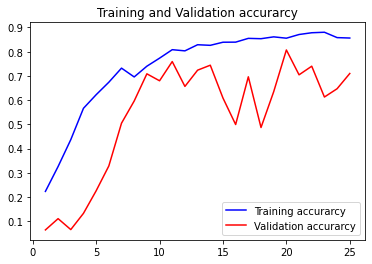

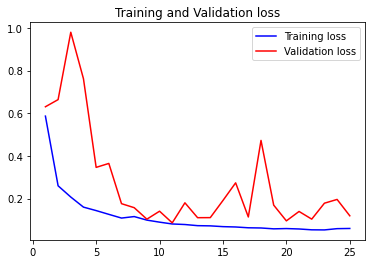

In \[54\]:

    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

    [INFO] Calculating model accuracy
    23/23 [==============================] - 9s 374ms/step - loss: 0.1195 - accuracy: 0.7100
    Test Accuracy: 70.99863290786743

In \[55\]:

    from tensorflow.keras.models import load_model

In \[56\]:

    model1 = load_model("leaf_model_v1")

In \[57\]:

    model1.summary()

    Model: "sequential_1"
    _________________________________________________________________
     Layer (type)                Output Shape              Param #   
    =================================================================
     conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                     
     activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                     
     batch_normalization_6 (Batc  (None, 256, 256, 32)     128       
     hNormalization)                                                 
                                                                     
     max_pooling2d_3 (MaxPooling  (None, 85, 85, 32)       0         
     2D)                                                             
                                                                     
     squeeze_excitation (squeeze  (None, 85, 85, 32)       0         
     Excitation)                                                     
                                                                     
     dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                     
     conv2d_6 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                     
     activation_8 (Activation)   (None, 85, 85, 64)        0         
                                                                     
     batch_normalization_7 (Batc  (None, 85, 85, 64)       256       
     hNormalization)                                                 
                                                                     
     squeeze_excitation_1 (squee  (None, 85, 85, 64)       0         
     zeExcitation)                                                   
                                                                     
     conv2d_7 (Conv2D)           (None, 85, 85, 64)        36928     
                                                                     
     activation_9 (Activation)   (None, 85, 85, 64)        0         
                                                                     
     batch_normalization_8 (Batc  (None, 85, 85, 64)       256       
     hNormalization)                                                 
                                                                     
     max_pooling2d_4 (MaxPooling  (None, 42, 42, 64)       0         
     2D)                                                             
                                                                     
     squeeze_excitation_2 (squee  (None, 42, 42, 64)       0         
     zeExcitation)                                                   
                                                                     
     dropout_5 (Dropout)         (None, 42, 42, 64)        0         
                                                                     
     conv2d_8 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                     
     activation_10 (Activation)  (None, 42, 42, 128)       0         
                                                                     
     batch_normalization_9 (Batc  (None, 42, 42, 128)      512       
     hNormalization)                                                 
                                                                     
     squeeze_excitation_3 (squee  (None, 42, 42, 128)      0         
     zeExcitation)                                                   
                                                                     
     conv2d_9 (Conv2D)           (None, 42, 42, 128)       147584    
                                                                     
     activation_11 (Activation)  (None, 42, 42, 128)       0         
                                                                     
     batch_normalization_10 (Bat  (None, 42, 42, 128)      512       
     chNormalization)                                                
                                                                     
     max_pooling2d_5 (MaxPooling  (None, 21, 21, 128)      0         
     2D)                                                             
                                                                     
     squeeze_excitation_4 (squee  (None, 21, 21, 128)      0         
     zeExcitation)                                                   
                                                                     
     dropout_6 (Dropout)         (None, 21, 21, 128)       0         
                                                                     
     flatten_1 (Flatten)         (None, 56448)             0         
                                                                     
     dense_2 (Dense)             (None, 1024)              57803776  
                                                                     
     activation_12 (Activation)  (None, 1024)              0         
                                                                     
     batch_normalization_11 (Bat  (None, 1024)             4096      
     chNormalization)                                                
                                                                     
     dropout_7 (Dropout)         (None, 1024)              0         
                                                                     
     dense_3 (Dense)             (None, 15)                15375     
                                                                     
     activation_13 (Activation)  (None, 15)                0         
                                                                     
    =================================================================
    Total params: 58,102,671
    Trainable params: 58,099,791
    Non-trainable params: 2,880
    _________________________________________________________________

In \[58\]:

    pred_img1 = "PredDataset/a.jpg"

In \[59\]:

    pred_img2 = "PredDataset/b.jpg"

In \[60\]:

    pred_img3 = "PredDataset/c.jpg"

In \[61\]:

    pred_img4 = "PredDataset/i.jpg"

In \[62\]:

    pred_list = []

In \[63\]:

    pred_list.append(convert_image_to_array(pred_img1))

In \[64\]:

    pred_list.append(convert_image_to_array(pred_img2))

In \[65\]:

    pred_list.append(convert_image_to_array(pred_img3))

In \[66\]:

    pred_list.append(convert_image_to_array(pred_img4))

In \[67\]:

    np_pred_list = np.array(pred_list, dtype=np.float16) / 225.0

In \[68\]:

    result = model1.predict(np_pred_list)

    1/1 [==============================] - 0s 275ms/step

In \[69\]:

    result

Out\[69\]:

    array([[9.9996412e-01, 7.3045326e-06, 1.0589773e-06, 2.5701790e-06,
            5.5234153e-07, 2.7509943e-09, 2.3069664e-05, 1.0693378e-06,
            1.9796737e-08, 2.1724688e-07, 1.1796255e-09, 1.1321138e-08,
            2.6143258e-08, 6.9113710e-09, 5.8481490e-11],
           [3.7936395e-04, 9.0896481e-01, 7.1436101e-10, 9.7982286e-07,
            8.6731672e-02, 7.6848448e-07, 5.6269448e-07, 3.5131518e-05,
            2.3030493e-09, 6.4712676e-04, 2.0961614e-10, 9.0839308e-08,
            3.1886995e-03, 5.0850533e-05, 4.5906884e-10],
           [2.2255264e-07, 3.3395793e-11, 9.9999976e-01, 4.3518801e-14,
            1.7289259e-15, 1.6579045e-14, 6.2995532e-11, 4.4822979e-10,
            1.2902024e-14, 6.2965899e-10, 9.5223560e-16, 4.9904450e-14,
            7.7560311e-12, 1.8917456e-16, 9.6659395e-14],
           [2.1899926e-02, 1.6597822e-07, 2.8001964e-06, 1.6108256e-02,
            1.8588759e-06, 9.0730047e-01, 1.1001068e-02, 2.2035975e-04,
            1.1303447e-05, 3.9666933e-03, 9.0383409e-08, 1.4392856e-06,
            3.9485514e-02, 6.5747244e-08, 1.0876519e-08]], dtype=float32)

In \[70\]:

    y_classes = result.argmax(axis=-1)

In \[71\]:

    y_classes

Out\[71\]:

    array([0, 1, 2, 5], dtype=int64)

In \[72\]:

    label_binarizer.classes_[y_classes]

Out\[72\]:

    array(['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
           'Potato___Early_blight', 'Tomato_Bacterial_spot'], dtype='<U43')

In \[ \]:

     

In \[ \]:

     

In \[ \]:

     

In \[ \]:

     

In \[ \]: